In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

定义数据类

In [2]:
class Dataset:
    def __init__(self, mode='given', means1=[-5, 0], means2=[0, 5]):
        if mode == 'given':
            self._given_data()
        if mode == 'random':
            self._rand_sample(means1, means2)

    def _rand_sample(self, means1, means2):
        means1 = np.array(means1)
        means2 = np.array(means2)
        covar = np.array([1, 0, 0, 1]).reshape(2,2)
        x1 = np.random.multivariate_normal(means1, covar, size=200)
        x2 = np.random.multivariate_normal(means2, covar, size=200)
        y1 = np.ones((200, 1))
        y2 = np.ones((200, 1)) * -1
        self._split(x1, y1, x2, y2)

    def _split(self, x1, y1, x2, y2):
        num1 = x1.shape[0]
        train_num1 = int(num1 * 0.8)
        num2 = x2.shape[0]
        train_num2 = int(num2 * 0.8)

        self.x_train = np.concatenate((x1[:train_num1],x2[:train_num2]),axis=0)
        self.y_train = np.concatenate((y1[:train_num1],y2[:train_num2]),axis=0)
        self.x_test = np.concatenate((x1[train_num1:],x2[train_num2:]),axis=0)
        self.y_test = np.concatenate((y1[train_num1:],y2[train_num2:]),axis=0)

    def _given_data(self):
        x = [0.2,0.7,
             0.3,0.3, 
             0.4,0.5, 
             0.6,0.5, 
             0.1,0.4, 
             0.4,0.6, 
             0.6,0.2, 
             0.7,0.4, 
             0.8,0.6, 
             0.7,0.5]
        y = [1,1,1,1,1,-1,-1,-1,-1,-1]
        self.x = np.array(x).reshape(-1,2)
        self.y = np.array(y).reshape(-1,1)
        assert(self.x.shape[0] == self.y.shape[0])

定义优化器以及损失函数

In [3]:
class Adagrad:
    def __init__(self, epsilon = 1e-6):
        #self.sigma = np.zeros((3,1))
        self.sigma = 0
        self.t = 0
        self.epsilon = epsilon
        
    def __call__(self, grad, lr):
        self.sigma = np.math.sqrt(((self.sigma**2) * self.t + grad**2)/(self.t + 1)) + self.epsilon
        self.t = self.t + 1
        return (lr * grad) / self.sigma

class RMSProp(Adagrad):
    def __init__(self, alpha=0.9):
        super(RMSProp,self).__init__()
        self.alpha = alpha
        
    def __call__(self, grad, lr):
        self.sigma = np.math.sqrt(self.alpha * self.sigma + (1-self.alpha)*grad**2)
        return (lr * grad) / self.sigma

class Momentum:
    def __init__(self, Lambda=0.9):
        #self.m = np.zeros((3,1))
        self.m = 0
        self.Lambda = Lambda

    def __call__(self, grad, lr):
        self.m = - self.Lambda * self.m + lr*grad
        return self.m

class Adam():
    def __init__(self, beta1=0.9, beta2=0.99, epsilon=1e-6):
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        #self.m = np.zeros((3,1))
        #self.v = np.zeros((3,1))
        self.m = 0
        self.v = 0
        self.t = 1

    def __call__(self, grad, lr):
        self.m = self.beta1 * self.m + (1-self.beta1) * grad
        self.v = self.beta2 * self.v + (1-self.beta2) * grad**2
        ## bias correction
        if self.t < 5:
            m = self.m/(1 - self.beta1**self.t)
            v = self.v/(1 - self.beta2**self.t)
        else:
            m = self.m
            v = self.v
        return lr * m / (np.math.sqrt(v) + self.epsilon)

def L2_loss(yhat, y):
    num_sample = y.shape[0]
    assert(yhat.shape == y.shape)
    loss = (1/num_sample) * np.sum((yhat - y)**2)

    return loss

定义线性回归模型

In [4]:
class LinearRegression:
    def __init__(self, lr=None, epoch=None, mode='g'):
        '''
        mode: g: Grandient Descent
              a: analysis
        '''
        self.mode = mode
        self.w = np.random.randn(3,1)
        if self.mode == 'g':
            self.lr = lr
            self.epoch = epoch
            assert(self.lr != None)
            assert(self.epoch != None)

    def __call__(self, x, y):

        x = x.reshape(-1,2)
        y = y.reshape(-1,1)
        expand_axis = np.ones((x.shape[0],1))
        x = np.concatenate((expand_axis, x), axis=-1)
        ## print(x.shape)
        
        if self.mode == 'a':
            x_gen_inverse = np.matmul(np.linalg.inv(np.matmul(x.T,x)),x.T)
            W = np.matmul(x_gen_inverse, y)
            
            self.w = W
            yhat = np.matmul(x, W)

            return yhat

        if self.mode == 'g':
            losses = []
            for i in range(self.epoch):
                yhat = np.matmul(x, self.w)
                loss = L2_loss(yhat, y)
                losses.append(loss)
                grad = self._calculate_grad(x, y)
                self.w -= self.lr * grad
                #if i % 50 == 0:
                #print('epoch: %i  loss: %.2f'%(i, loss))

            return yhat, losses

    def _calculate_grad(self, x, y):
        num_sample = x.shape[0]
        aver = (2/num_sample)
        ## print((np.matmul(x,self.w) - y).T.shape)
        ## print(x.shape)
        grad = aver * np.matmul((np.matmul(x,self.w) - y).T, x)
        ## print(grad.shape)

        return grad.T


    def eval(self, x, y):
        test_num = x.shape[0]
        expand_axis = np.ones((x.shape[0],1))
        x = np.concatenate((expand_axis, x), axis=-1)
        yhat = np.matmul(x, self.w)
        yhat = np.sign(yhat)
        assert(len(yhat) == len(y))
        correct_num = len(np.where(yhat == y)[0])
        print('accuracy: %.2f'%(correct_num/test_num))

生成随机点数据并可视化

x_train: (320, 2)
y_train: (320, 1)
x_test: (80, 2)
y_test: (80, 1)


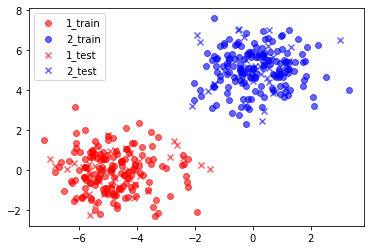

In [5]:
data2 = Dataset(mode='random')
x_train = data2.x_train
y_train = data2.y_train
x_test = data2.x_test
y_test = data2.y_test
print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_test: {}".format(x_test.shape))
print("y_test: {}".format(y_test.shape))
c1 = plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.6, marker='o', c='red')
c2 = plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.6, marker='o', c='blue')
c3 = plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.6, marker='x', c='red')
c4 = plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.6, marker='x', c='blue')
plt.legend(handles=[c1, c2, c3, c4],labels=['1_train','2_train', '1_test', '2_test'],loc='best')
plt.show()

上图为随机采样得到的第一组数据，以下分别使用解析法和梯度下降法得到分类器

使用解析解算法直接得到W

accuracy: 1.00
w: [[-0.18011082]
 [-0.18914842]]
b: [0.04536224]


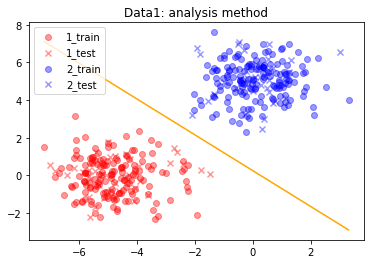

In [6]:
model1 = LinearRegression(mode='a')
yhat = model1(x_train, y_train)
model1.eval(x_test, y_test)
w, b = model1.w[1:], model1.w[0]
print('w: {}'.format(w))
print('b: {}'.format(b))
c1 = plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.4, marker='o', c='red')
c2 = plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.4, marker='o', c='blue')
c3 = plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.4, marker='x', c='red')
c4 = plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.4, marker='x', c='blue')
xmax = np.max(x_train[:,0])
xmin = np.min(x_train[:,0])
point1 = [xmin,xmax]
point2 = [-(w[0]*xmin+b)/w[1],-(w[0]*xmax+b)/w[1]]
plt.plot(point1,point2,c='orange')
plt.legend(handles=[c1, c3, c2, c4],labels=['1_train','1_test','2_train','2_test'],loc='best')
plt.title('Data1: analysis method')
plt.show()

使用梯度下降的方法

accuracy: 0.91
w: [[-0.46554063]
 [ 0.08837876]]
b: [-1.42696041]


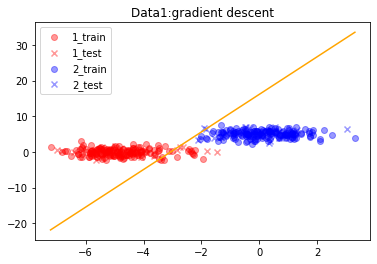

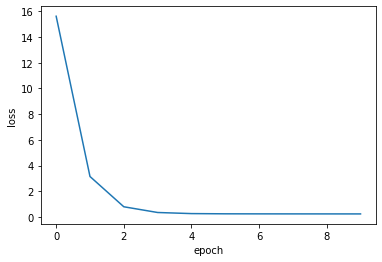

In [7]:
lr = 0.02
epoch = 10

model2 = LinearRegression(lr=lr, epoch=epoch, mode='g')
yhat, loss = model2(x_train, y_train)
model2.eval(x_test, y_test)
w, b = model2.w[1:], model2.w[0]
print('w: {}'.format(w))
print('b: {}'.format(b))
c1 = plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.4, marker='o', c='red')
c2 = plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.4, marker='o', c='blue')
c3 = plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.4, marker='x', c='red')
c4 = plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.4, marker='x', c='blue')
xmax = np.max(x_train[:,0])
xmin = np.min(x_train[:,0])
point1 = [xmin,xmax]
point2 = [-(w[0]*xmin+b)/w[1],-(w[0]*xmax+b)/w[1]]
plt.plot(point1,point2,c='orange')
plt.legend(handles=[c1, c3, c2, c4],labels=['1_train','1_test','2_train','2_test'],loc='best')
plt.title('Data1:gradient descent')
plt.show()


epoch = np.arange(0,epoch)
loss = np.array(loss)
plt.plot(epoch,loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

改变数据分布 means1 = [1, 0] measn2 = [0, 1]

x_train: (320, 2)
y_train: (320, 1)
x_test: (80, 2)
y_test: (80, 1)


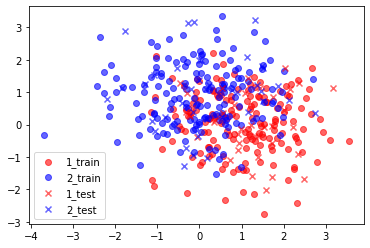

In [8]:
data3 = Dataset(mode='random', means1=[1,0], means2=[0,1])
x_train = data3.x_train
y_train = data3.y_train
x_test = data3.x_test
y_test = data3.y_test
print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_test: {}".format(x_test.shape))
print("y_test: {}".format(y_test.shape))
c1 = plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.6, marker='o', c='red')
c2 = plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.6, marker='o', c='blue')
c3 = plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.6, marker='x', c='red')
c4 = plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.6, marker='x', c='blue')
plt.legend(handles=[c1, c2, c3, c4],labels=['1_train','2_train', '1_test', '2_test'],loc='best')
plt.show()

accuracy: 0.72
w: [[ 0.34354038]
 [-0.31479862]]
b: [-0.0234686]


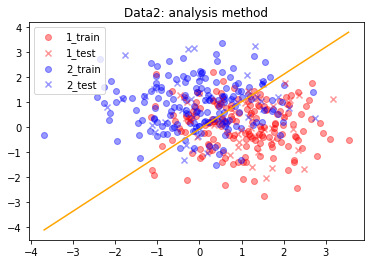

In [9]:
model1 = LinearRegression(mode='a')
yhat = model1(x_train, y_train)
model1.eval(x_test, y_test)
w, b = model1.w[1:], model1.w[0]
print('w: {}'.format(w))
print('b: {}'.format(b))
c1 = plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.4, marker='o', c='red')
c2 = plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.4, marker='o', c='blue')
c3 = plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.4, marker='x', c='red')
c4 = plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.4, marker='x', c='blue')
xmax = np.max(x_train[:,0])
xmin = np.min(x_train[:,0])
point1 = [xmin,xmax]
point2 = [-(w[0]*xmin+b)/w[1],-(w[0]*xmax+b)/w[1]]
plt.plot(point1,point2,c='orange')
plt.legend(handles=[c1, c3, c2, c4],labels=['1_train','1_test','2_train','2_test'],loc='best')
plt.title('Data2: analysis method')
plt.show()

accuracy: 0.71
w: [[ 0.32686181]
 [-0.33117659]]
b: [0.0087514]


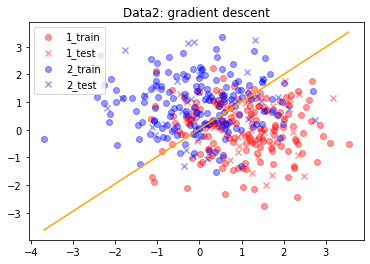

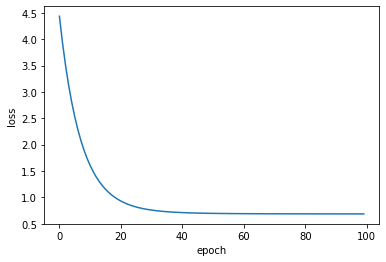

In [10]:
lr = 0.02
epoch = 100

model2 = LinearRegression(lr=lr, epoch=epoch, mode='g')
yhat, loss = model2(x_train, y_train)
model2.eval(x_test, y_test)

w, b = model2.w[1:], model2.w[0]
print('w: {}'.format(w))
print('b: {}'.format(b))

c1 = plt.scatter(x_train[:160,0], x_train[:160,1], alpha=0.4, marker='o', c='red')
c2 = plt.scatter(x_train[160:,0], x_train[160:,1], alpha=0.4, marker='o', c='blue')
c3 = plt.scatter(x_test[:40,0], x_test[:40,1], alpha=0.4, marker='x', c='red')
c4 = plt.scatter(x_test[40:,0], x_test[40:,1], alpha=0.4, marker='x', c='blue')
xmax = np.max(x_train[:,0])
xmin = np.min(x_train[:,0])
point1 = [xmin,xmax]
point2 = [-(w[0]*xmin+b)/w[1],-(w[0]*xmax+b)/w[1]]
plt.plot(point1,point2,c='orange')
plt.legend(handles=[c1, c3, c2, c4],labels=['1_train','1_test','2_train','2_test'],loc='best')
plt.title('Data2: gradient descent')
plt.show()

epoch = np.arange(0,epoch)
loss = np.array(loss)
plt.plot(epoch,loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

接下来分别测试各种optimizer的性能
使运行相同的epoch = 10，学习率lr = 0.4
观察loss函数曲线

首先定义函数 f(x) = x * cos(0.25 * pi * x)

In [11]:
class func:
    def __init__(self):
        pass

    def __call__(self, x):
        y = x * np.cos(0.25 * np.pi * x)
        grad = self._calculate_grad(x)
        return y, grad

    def _calculate_grad(self, x):
        grad = np.cos(0.25 * np.pi * x) - 0.25 * x * np.sin(0.25 * np.pi * x)
        return grad

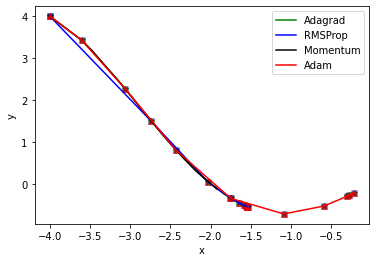

In [12]:
epoch = 10
lr = 0.4

f = func()
x = np.ones(4) * -4
y = np.ones(4) * f(-4)[0]
grad = np.zeros(4)
optimizer = [Adagrad(), RMSProp(), Momentum(), Adam()]

xs = []
ys = []
for i in range(epoch):
    ## calculate current value
    for j in range(4):
        y[j], grad[j] = f(x[j])
    ## save result
    xs.append([x[0], x[1], x[2], x[3]])
    ys.append([y[0], y[1], y[2], y[3]])
    ## updata
    for j in range(4):
        x[j] -= optimizer[j](grad[j], lr)
xs = np.array(xs)
ys = np.array(ys)

## show result
plt.plot(xs[:, 0],ys[:, 0], c='green', label='Adagrad')
plt.plot(xs[:, 1],ys[:, 1], c='blue', label='RMSProp')
plt.plot(xs[:, 2],ys[:, 2], c='black', label='Momentum')
plt.plot(xs[:, 3],ys[:, 3], c='red', label='Adam')

plt.scatter(xs[:, 1::2],ys[:, 1::2], alpha=0.5, c='green', marker='o')
plt.scatter(xs[:, 1::2],ys[:, 1::2], alpha=0.5, c='blue', marker='x')
plt.scatter(xs[:, 1::2],ys[:, 1::2], alpha=0.5, c='black', marker='*')
plt.scatter(xs[:, 1::2],ys[:, 1::2], alpha=0.5, c='red', marker='^')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

在该测试中，可以看出Adam优化速度较快，同时其momentum机制会使其越过optimal点；其他优化策略在本问题上效果较为接近

迭代50次并修改Adam的beta1为0.99

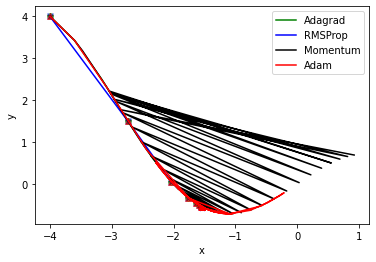

In [13]:
epoch = 50
lr = 0.4

f = func()
x = np.ones(4) * -4
y = np.ones(4) * f(-4)[0]
grad = np.zeros(4)
optimizer = [Adagrad(), RMSProp(), Momentum(), Adam(beta1=0.9)]

xs = []
ys = []
for i in range(epoch):
    ## calculate current value
    for j in range(4):
        y[j], grad[j] = f(x[j])
    ## save result
    xs.append([x[0], x[1], x[2], x[3]])
    ys.append([y[0], y[1], y[2], y[3]])
    ## updata
    for j in range(4):
        x[j] -= optimizer[j](grad[j], lr)
xs = np.array(xs)
ys = np.array(ys)

## show result
plt.plot(xs[:, 0],ys[:, 0], c='green', label='Adagrad')
plt.plot(xs[:, 1],ys[:, 1], c='blue', label='RMSProp')
plt.plot(xs[:, 2],ys[:, 2], c='black', label='Momentum')
plt.plot(xs[:, 3],ys[:, 3], c='red', label='Adam')

plt.scatter(xs[:, 1::5],ys[:, 1::5], alpha=0.5, c='green', marker='o')
plt.scatter(xs[:, 1::5],ys[:, 1::5], alpha=0.5, c='blue', marker='x')
plt.scatter(xs[:, 1::5],ys[:, 1::5], alpha=0.5, c='black', marker='*')
plt.scatter(xs[:, 1::5],ys[:, 1::5], alpha=0.5, c='red', marker='^')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

可以看出，由于momentum并没有对梯度进行自适应，使其在optimal点附近来回振荡，甚至梯度累加越加越大，最后导致不能收敛